# Import Modules

In [1]:
import pandas as pd
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')


from langdetect import detect
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Fetch Dataset

In [2]:
#current directory containing dataset
directory = "Dataset/"

#read training set
train_csv = pd.read_csv(directory+"mediaeval-2015-trainingset.txt", sep="\t", quoting=3)
train_df = pd.DataFrame(data = train_csv)

#read test set
test_csv = pd.read_csv(directory+"mediaeval-2015-testset.txt", sep="\t", quoting=3)
test_df = pd.DataFrame(data = test_csv)


#train_df = pandas.read_table("Dataset/mediaeval-2015-trainingset.txt", sep="\t",lineterminator='\n', skiprows=(0),  header=(0))
#test_df = pandas.read_table("Dataset/mediaeval-2015-testset.txt", sep="\t", lineterminator='\n', skiprows=(0),  header=(0))


# Data Characterisation and Visualisation

In [ ]:
#Dataset information, mainly different fields and size
train_df.info()
print()
test_df.info()

In [ ]:
#shape of training/test sets
print(train_df.shape)
print(test_df.shape)

In [ ]:
#example of dataset entities
train_df.head()

In [3]:
#renaming ImageId(s) as clunky column name
train_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)

test_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)


In [ ]:
#events categorised by ImageID (train)
print("Train:")
selected_events = train_df["imageId"].str.split('_').str[0].value_counts()
print(selected_events) 
selected_events.plot(kind="barh")
plt.title("Training Set Events")
plt.show()



In [ ]:
#events categorised by ImageID (test)
print("Test:")
selected_events = test_df["imageId"].str.split('_').str[0].value_counts()
print(selected_events) 
selected_events.plot(kind="barh")
plt.title("Test Set Events")
plt.show()

In [ ]:
#example tweets for different events

event = "sandy" #change variable for different events

total_df = train_df + test_df
selected_tweets = total_df[total_df["imageId"].str.contains(event, na=False)]["tweetText"].head(30)
print(selected_tweets)

In [ ]:
#number of languages in training set
trainLangs = {}

for text in train_df["tweetText"]:
    try:
        lan = detect(text)
    except:
        pass
        lan = "Unknown"
    trainLangs[lan] = trainLangs.get(lan, 0) + 1
  
print(trainLangs)

# top 4 languages 
top_langs = dict(sorted(trainLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(trainLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Training Set Languages")
plt.show()



In [ ]:
#number of languages in test set
testLangs = {}

for text in test_df["tweetText"]:
    try:
        lan = detect(text)
    except:
        pass
        lan = "Unknown"
    testLangs[lan] = testLangs.get(lan, 0) + 1
  

print(testLangs)

# top 4 languages 
top_langs = dict(sorted(testLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(testLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Test Set Languages")
plt.show()



In [4]:
#Searching for duplicate tweets in training
print(train_df["tweetText"].describe())
print(f"duplicates:  {train_df['tweetText'].duplicated().sum()}")



count                                                 14483
unique                                                12542
top       Unbelievable scene flying over #StatenIsland i...
freq                                                     42
Name: tweetText, dtype: object
duplicates:  1941


In [ ]:
#Searching for duplicate tweets in test
print(test_df["tweetText"].describe())
print(f"duplicates:  {test_df['tweetText'].duplicated().sum()}")

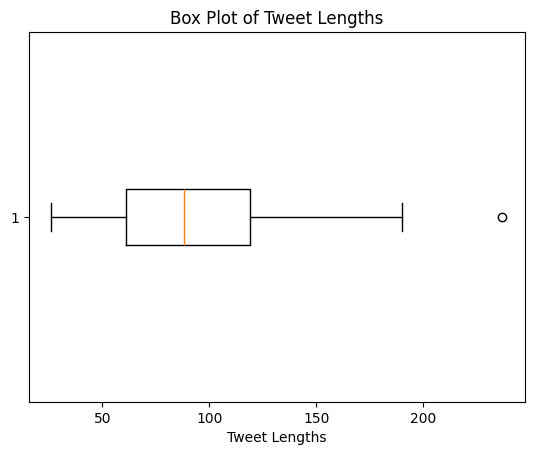

Highest Reasonable Value: 190.0


In [5]:
#compare lengths of tweets in training
train_df["tweetLength"] = train_df["tweetText"].apply(len)

bp = plt.boxplot(train_df["tweetLength"], vert=False)

#use right whisker of box plot to get highest reasonable value
max_legit_value = bp["whiskers"][1].get_data()[0][1]

plt.title("Box Plot of Tweet Lengths")
plt.xlabel("Tweet Lengths")
plt.show()

print(f"Highest Reasonable Value: {max_legit_value}")

In [6]:
#investigate 1 outliers
#top_indices = train_df["tweetLength"].nlargest(1).index
#longest_tweets = train_df.loc[top_indices, "tweetText"]

longest_tweet = train_df['tweetText'].loc[train_df['tweetText'].str.len().idxmax()]

print(longest_tweet)
print(f"Length: {len(longest_tweet)}")

#tweet looks valid






This can't be real...RT @ropgrady: \355\240\275\355\270\263\355\240\275\355\270\263\355\240\275\355\270\263 #wtf #hurricane #sandy #nyc #statueofliberty #waves \355\240\274\355\274\212\355\240\275\355\267\275⚡☔ @ NYC http://t.co/CiWRW36n
Length: 237


In [ ]:
# NOT USED after changing how dataset is read in
#used to debug longest tweet cause

#n = 15
#print(f"Tweet:\n{longest_tweets.values[n]}\nLength: {len(longest_tweets.values[n])}")

#Above process confirms that the 15th longest tweet 
#(according to the box plot) is actually the correct longest tweet

# Data Preprocessing

- remove broken length tweets - done
- remove duplicates 
- Change humor to fake - done
- Remove URLs
- Remove certain punctiation
- Remove whitespace and stopwords 
- Tokenise


- Remove re-tweets and reposts
- Remove usernames
- Remove emojis
- Don't remove #
- Don't remove URLS





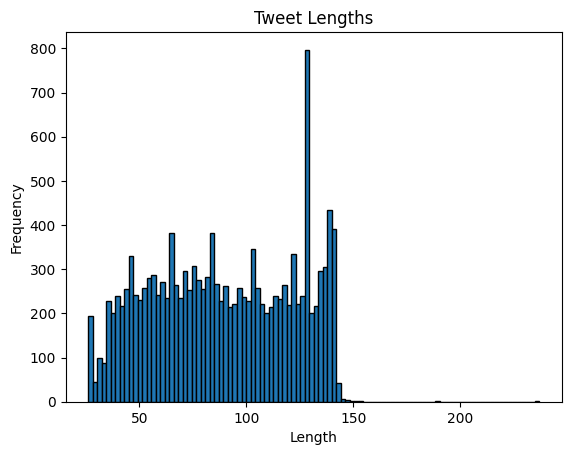

4046     This can't be real...RT @ropgrady: \355\240\27...
12801    FBI ΰΉ€ΰΈΰΈΆΰΈ ΰΈ²ΰΈΰΈ΅ΰΈ·ΰΈ­ΰΈ£ΰΈ°ΰΉ€ΰΈΰΈ΄...
12904    FBI ΰΉ€ΰΈΰΈΆΰΈ ΰΈ²ΰΈΰΈ΅ΰΈ·ΰΈ­ΰΈ£ΰΈ°ΰΉ€ΰΈΰΈ΄...
9334     Where that pic taken? RT @DaQueennnBee: My pra...
6714     Hurricane Sandy bring sharks to New Jersey \35...
12692    4Chan may have found the bomber:\nhttp://t.co/...
14474    *loses all hope for society* \"@snopes: The sn...
7826     RT @dj609: So this is #hurricanesandy over #ne...
9918     &amp; big thank you to all our police/ firefig...
2971     Duty &amp; Honor were the Call at Tomb of the ...
Name: tweetText, dtype: object

This can't be real...RT @ropgrady: \355\240\275\355\270\263\355\240\275\355\270\263\355\240\275\355\270\263 #wtf #hurricane #sandy #nyc #statueofliberty #waves \355\240\274\355\274\212\355\240\275\355\267\275⚡☔ @ NYC http://t.co/CiWRW36n
Length: 237


In [7]:
#NOT NEEDED
#removing 15 outliers containing multiple tweets (tweets longer than 237)
train_df = train_df[train_df["tweetLength"] < 238]

#new distribution of tweet lengths
plt.hist(train_df["tweetLength"], bins=100, edgecolor='black')

plt.title("Tweet Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

#top 10 new longest tweets
top_indices = train_df["tweetLength"].nlargest(10).index
longest_tweets = train_df.loc[top_indices, "tweetText"]
print(longest_tweets)

#longest tweet
print(f"\n{longest_tweets.values[0]}\nLength: {len(longest_tweets.values[0])}")


In [8]:
#replace 'humor' label with 'fake'
train_df['label'] = train_df['label'].replace('humor', 'fake')
test_df['label'] = test_df['label'].replace('humor', 'fake')

#replace 'humor' label with 'fake' and map to 1 and 0 for ease of use when training and evaluating. Fake: 1, real: 0
#train_df['label'] = train_df['label'].map({'fake': 1, 'humor': 1, 'real': 0})
#test_df['label'] = test_df['label'].map({'fake': 1, 'humor': 1, 'real': 0})


In [15]:
#Clean tweet text by removing unnecessary noise
#experiment with for best performance (some processes achieve similiar things)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import swifter

#train_df["cleanText"] = train_df["tweetText"]
#test_df["cleanText"] = test_df["tweetText"]

sw = nltk.corpus.stopwords.words()
lemmatiser = WordNetLemmatizer()

def smartCleanText(text):
    
    #remove URLs
    text = re.sub(r'http\S+|\\\/\S+', ' ', text)

    #remove usernames 
    text = re.sub(r'@\w*', " ", text)

    #remove punctuation
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)

    #normalise whitespace 
    text = re.sub(r'\s+', ' ', text)

    #tokenise
    words = word_tokenize(text)

    #remove stopwords 
    words = [word for word in words if word.lower() not in sw]

    #lemmatise
    words = list(map(lemmatiser.lemmatize, words))

    #ne chunks and pos tagging
    text = str(nltk.ne_chunk(nltk.pos_tag(words)))

    #clean tree
    text = text.replace("\n", "")
    text = text.replace("(S ", "")
    text = text.replace("/", " ")
    text = text.replace("(", "")
    text = text.replace(")", "")

    ##lowercase text
    text = text.lower()

    #normalise whitespace 
    text = re.sub(r'\s+', ' ', text)
    

    return text

def cleanText(text):
    
    #remove URLs
    text = re.sub(r'http\S+|\\\/\S+', ' ', text)

    #remove usernames 
    text = re.sub(r'@\w*', " ", text)

    #remove punctuation
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)

    #normalise whitespace 
    text = re.sub(r'\s+', ' ', text)

    #tokenise
    words = word_tokenize(text)

    #remove stopwords 
    words = [word for word in words if word.lower() not in sw]

    #lemmatise
    words = list(map(lemmatiser.lemmatize, words))  

    text = ' '.join(words)
    ##lowercase text
    text = text.lower()  

    return text



#apply cleantext
train_df['smartCleanText'] = train_df['tweetText'].swifter.apply(smartCleanText)
test_df['smartCleanText'] = test_df['tweetText'].swifter.apply(smartCleanText)

train_df['cleanText'] = train_df['tweetText'].swifter.apply(cleanText)
test_df['cleanText'] = test_df['tweetText'].swifter.apply(cleanText)
#remove extra white space
#train_df['cleanText'] = train_df['cleanText'].str.replace(r'\s+', ' ', regex=True)
#test_df['cleanText'] = test_df['cleanText'].str.replace(r'\s+', ' ', regex=True)


#remove stopwords
#sw = nltk.corpus.stopwords.words()
#train_df['cleanText'] = train_df['cleanText'].apply(lambda x: ' '.join([w for w in x.split() if w not in sw]))
#test_df['cleanText'] = test_df['cleanText'].apply(lambda x: ' '.join([w for w in x.split() if w not in sw]))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
Pandas Apply: 100%|██████████| 3781/3781 [00:03<00:00, 1158.40it/s]


In [13]:
## TESTER BLOCK
#text = "how many retweets can we get for the soldiers guarding the tomb of unknown soldiers during hurricane sandy america"
##text = "HOW MANY RETWEETS CAN WE GET FOR THE SOLDIERS GUARDING THE TOMB OF UNKOWN SOLDERIS DURING HURRICANE SANDY AMERICA"
#
##remove URLs
#text = re.sub(r'http\S+|\\\/\S+', ' ', text)
#
##remove usernames 
#text = re.sub(r'@\w*', " ", text)
#
##remove punctuation
#text = re.sub(r'[^a-zA-Z ]+', ' ', text)
#
##normalise whitespace 
#text = re.sub(r'\s+', ' ', text)
#
##tokenise
#words = word_tokenize(text)
#print(words)
#
##remove stopwords 
#words = [word for word in words if word.lower() not in sw]
#
#print(words)
##lemmatise
#words = list(map(lemmatiser.lemmatize, words))
#
##ne chunks and pos tagging
#text = str(nltk.ne_chunk(nltk.pos_tag(words)))
#
##clean tree
#text = text.replace("\n", "")
#text = text.replace("(S ", "")
#text = text.replace("/", " ")
#text = text.replace("(", "")
#text = text.replace(")", "")
#
###lowercase text
#text = text.lower()
#
##normalise whitespace 
#text = re.sub(r'\s+', ' ', text)
#
#
#
#print(text)

['how', 'many', 'retweets', 'can', 'we', 'get', 'for', 'the', 'soldiers', 'guarding', 'the', 'tomb', 'of', 'unknown', 'soldiers', 'during', 'hurricane', 'sandy', 'america']
['retweets', 'soldiers', 'guarding', 'tomb', 'unknown', 'soldiers', 'hurricane', 'sandy', 'america']
 retweets nns soldier vbp guarding vbg tomb nn unknown jj soldier nn hurricane nn sandy nn america nn


In [ ]:
##lemmatise to reduce total word count
#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import WhitespaceTokenizer
#
#lemmatiser = WordNetLemmatizer()
#tokeniser = WhitespaceTokenizer()
#
#train_df['cleanText'] = train_df['cleanText'].apply(lambda x: ' '.join([lemmatiser.lemmatize(w) for w in tokeniser.tokenize(x)]))
#


In [16]:
#remove duplicates
print("cleanText")
print(train_df["cleanText"].duplicated().sum())
train_df.drop_duplicates(subset=["cleanText"], keep="first", inplace=True)
print(train_df["cleanText"].duplicated().sum())

print("\nSmartCleanText")
print(train_df["smartCleanText"].duplicated().sum())
train_df.drop_duplicates(subset=["smartCleanText"], keep="first", inplace=True)
print(train_df["smartCleanText"].duplicated().sum())


cleanText
167
0

SmartCleanText
0
0


Longest Tweet:
rt bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls
Length: 110


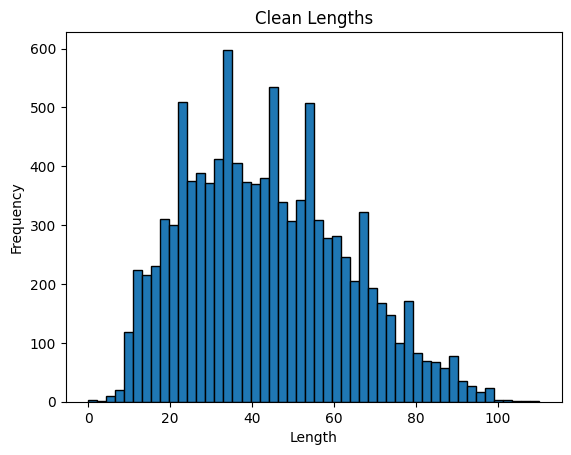

In [17]:
#lengths of cleaned text 
train_df["cleanLength"] = train_df["cleanText"].apply(len)

top_indices = train_df["cleanLength"].nlargest(16).index
longest_tweets = train_df.loc[top_indices, "cleanText"]

print(f"Longest Tweet:\n{longest_tweets.values[0]}\nLength: {len(longest_tweets.values[0])}")

#new distribution of cleaned lengths
plt.hist(train_df["cleanLength"], bins=50, edgecolor='black')

plt.title("Clean Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [ ]:
#tokenise
#from nltk.tokenize import word_tokenize
#
## Assuming df_train is your DataFrame and 'cleanText' is the column you want to tokenize
#train_df["tokenisedText"] = train_df["cleanText"].apply(lambda x: word_tokenize(x))
#
#test_df["tokenisedText"] = test_df["cleanText"].apply(lambda x: word_tokenize(x))



In [18]:
#train_df.head(20)
display(train_df)

,tweetId,tweetText,userId,imageId,username,timestamp,label,tweetLength,smartCleanText,cleanText,cleanLength
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,134,acuerdan jj cula nn despu nn ana nn recuerda ...,acuerdan cula despu ana recuerda pasando hurac...,52
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,133,person miren nnp person sandy nnp ny nnp trem...,miren sandy ny tremenda imagen hurac parece in...,65
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,116,gpe buena nnp foto nn person hurac nnp sandy ...,buena foto hurac sandy recuerda cula independe...,59
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,46,scary jj shit vbd hurricane nn ny nnp,scary shit hurricane ny,23
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,89,fave jj place nn world nn nyc nn hurricane nn...,fave place world nyc hurricane sandy statueofl...,52
...,...,...,...,...,...,...,...,...,...,...,...
14478,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake,71,slap nn organization tweetdeck nnp pigfish nnp,slap tweetdeck pigfish,22
14479,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake,124,species nns person fish nnp found vbd person ...,species fish found brazil photoshop,35
14480,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake,57,call nn organization pigfish nn,call pigfish,12
14481,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake,81,gpe pigfish jj dopo nn pescecane nn pesce nn m...,pigfish dopo pescecane pesce maiale,35


In [ ]:
test_df.head(5)

# Pipeline Design

In [37]:
#import relevant sklearn modules
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split


#used to perform tf-idf feature selection in the pipelines
#bow = CountVectorizer()

ngram = CountVectorizer(ngram_range=(1,1))

tfidf = TfidfVectorizer()

#used to perform  dimension reduction in the pipelines
dr = TruncatedSVD(n_components=100)

#dr = NMF(n_components=100)


In [38]:
#pipeline 1 using Multinomial Naive Bayes
pipeline_1 = mnb_pipeline = Pipeline([
    ('fs', tfidf),
    #('dr', dr),
    ('mnb', MultinomialNB())
])


#training on entire training set
pipeline_1.fit(train_df["smartCleanText"], train_df["label"])

#predicting on test set
pred_test_1 = pipeline_1.predict(test_df["smartCleanText"])


In [41]:
#pipeline_2 using Stochastic Gradient Descent
pipeline_2 = Pipeline([
    ('fs', tfidf),
    #('dr', dr),
    ('sgd', SGDClassifier(random_state=69))
])


#training on entire training set

pipeline_2.fit(train_df["cleanText"], train_df["label"])

#predicting on test set

pred_test_2 = pipeline_2.predict(test_df["cleanText"])

# Model Training and Testing

In [ ]:
#USED for quick testing using training validation set, not used in final results
#splitting training set into train and val
#x = features, y = labels
X_train, X_val, y_train, y_val = train_test_split(train_df["cleanText"], train_df["label"], test_size=0.2, random_state=69)

#training pipeline_1 
pipeline_1.fit(X_train, y_train)

#evaluating pipeline_1
accuracy_1 = pipeline_1.score(X_val, y_val)
print("MNB accuracy:   %0.3f" % accuracy_1)

#training pipeline_2 
pipeline_2.fit(X_train, y_train)

#evaluating pipeline_1
accuracy_2 = pipeline_2.score(X_val, y_val)
print("SGD accuracy:   %0.3f" % accuracy_2)


In [ ]:
#training on entire training set
pipeline_1.fit(train_df["cleanText"], train_df["label"])

#predicting on test set
pred_test_1 = pipeline_1.predict(test_df["cleanText"])


In [ ]:
#training on entire training set

pipeline_2.fit(train_df["cleanText"], train_df["label"])

#predicting on test set

pred_test_2 = pipeline_2.predict(test_df["cleanText"])

# Evaluation

MNB classification report:

              precision    recall  f1-score   support

        fake       0.88      0.97      0.92      2564
        real       0.93      0.72      0.81      1217

    accuracy                           0.89      3781
   macro avg       0.90      0.85      0.87      3781
weighted avg       0.89      0.89      0.89      3781


SGD classification report:

              precision    recall  f1-score   support

        fake       0.89      0.90      0.89      2564
        real       0.77      0.76      0.77      1217

    accuracy                           0.85      3781
   macro avg       0.83      0.83      0.83      3781
weighted avg       0.85      0.85      0.85      3781



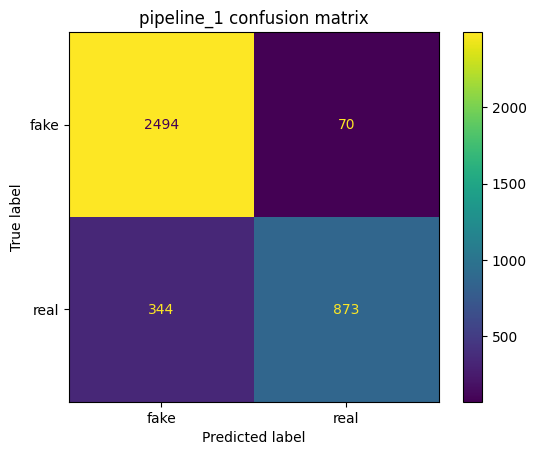

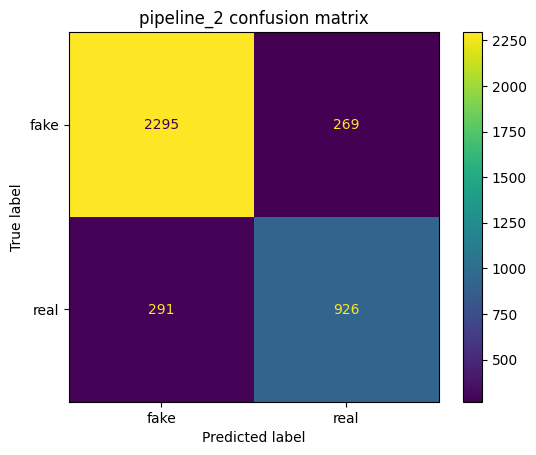

In [42]:
#evaluating pipeline performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#Classification Report 1

report_1 = classification_report(test_df['label'], pred_test_1)
print("MNB classification report:\n")
print(report_1)


#Classification Report 2
report_2 = classification_report(test_df['label'], pred_test_2)
print("\nSGD classification report:\n")
print(report_2)

#confusion matrix for pipeline_1

cm_1 = confusion_matrix(test_df['label'], pred_test_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipeline_1.classes_).plot()

plt.title("pipeline_1 confusion matrix")
plt.show()

#confusion matrix for pipeline_2

cm_2 = confusion_matrix(test_df['label'], pred_test_2)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipeline_2.classes_).plot()

plt.title("pipeline_2 confusion matrix")
plt.show()





